In [1]:
# ===========================================
# Logistic Regression Lab: Patient Experience
# ===========================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [84]:

# -----------------------------
# 1. Generate synthetic dataset
# -----------------------------

np.random.seed(42)
n = 1000

data = pd.DataFrame({
    'cleanliness': np.random.normal(7, 1.5, n).clip(1, 10),
    'communication': np.random.normal(7, 1.5, n).clip(2, 10),
    'staff_friendliness': np.random.normal(7, 1.5, n).clip(1, 10),
    'timeliness': np.random.normal(7, 1.5, n).clip(1, 10),
    'discharge_clarity': np.random.normal(7, 1.5, n).clip(1, 10)
})

# Logistic model coefficients
β0 = -13
β_clean = 0.1
β_comm = 0.1
β_staff = 0.8    # strong effect
β_time = 0.2
β_discharge = 0.9  # strongest effect

# Linear predictor
log_odds = (β0 
            + β_clean * data.cleanliness
            + β_comm * data.communication
            + β_staff * data.staff_friendliness
            + β_time * data.timeliness
            + β_discharge * data.discharge_clarity)

# Convert to probabilities via logistic function
prob = 1 / (1 + np.exp(-log_odds))
print(f"Probability: {prob}")

data['LTR'] = np.random.binomial(1, prob)

# Save to CSV
data.to_csv('patient_experience.csv', index=False)
print("✅ patient_experience.csv created!")



Probability: 0      0.362654
1      0.793195
2      0.680362
3      0.935004
4      0.101468
         ...   
995    0.864569
996    0.931632
997    0.941456
998    0.972741
999    0.610912
Length: 1000, dtype: float64
✅ patient_experience.csv created!


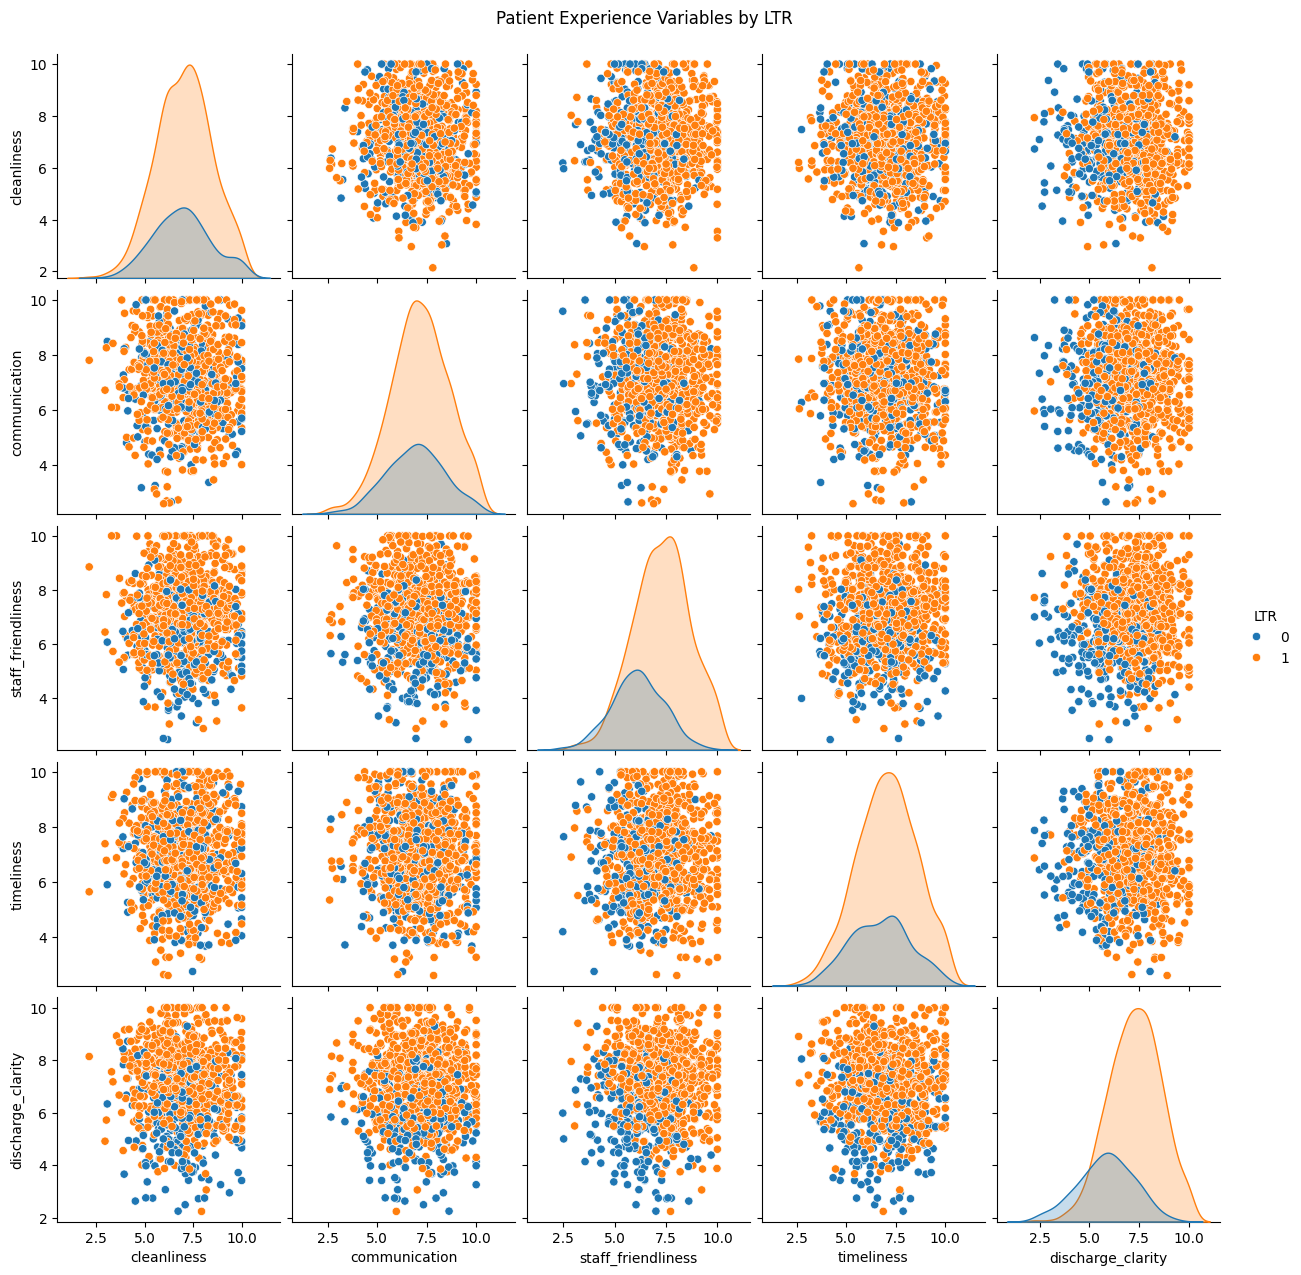

In [85]:
# -----------------------------
# 2. Quick exploration
# -----------------------------
sns.pairplot(data, hue='LTR', diag_kind='kde')
plt.suptitle("Patient Experience Variables by LTR", y=1.02)
plt.show()


In [86]:

# -----------------------------
# 3. Train/test split & scaling
# -----------------------------
X = data[['cleanliness','communication','staff_friendliness','timeliness','discharge_clarity']]
y = data['LTR']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [87]:

# -----------------------------
# 4. Fit logistic regression
# -----------------------------
model = LogisticRegression()
model.fit(X_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Create dataframe of coefficients
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': np.exp(model.coef_[0])
})
print("\nCoefficient Summary:")
print(coef_df.sort_values('Coefficient', ascending=False))


Intercept: [1.64099473]
Coefficients: [[0.00750291 0.17856633 1.13224719 0.31754177 1.27463486]]

Coefficient Summary:
             Variable  Coefficient  Odds_Ratio
4   discharge_clarity     1.274635    3.577395
2  staff_friendliness     1.132247    3.102621
3          timeliness     0.317542    1.373747
1       communication     0.178566    1.195502
0         cleanliness     0.007503    1.007531


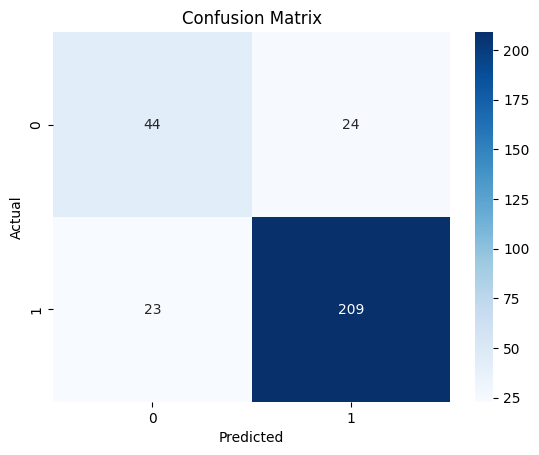


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65        68
           1       0.90      0.90      0.90       232

    accuracy                           0.84       300
   macro avg       0.78      0.77      0.78       300
weighted avg       0.84      0.84      0.84       300



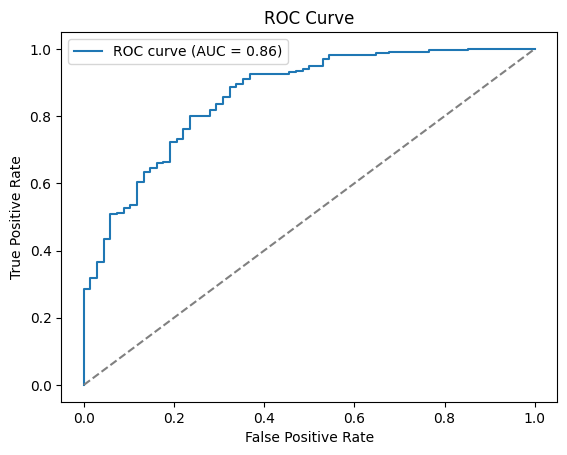

In [ ]:

# -----------------------------
# 5. Evaluate model
# -----------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
# y_pred = (y_prob >= 0.6).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

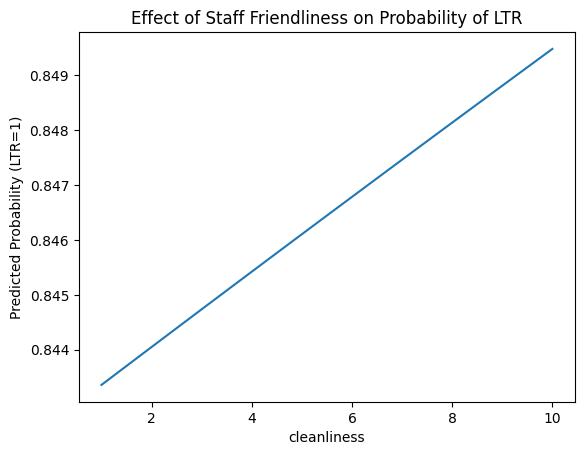

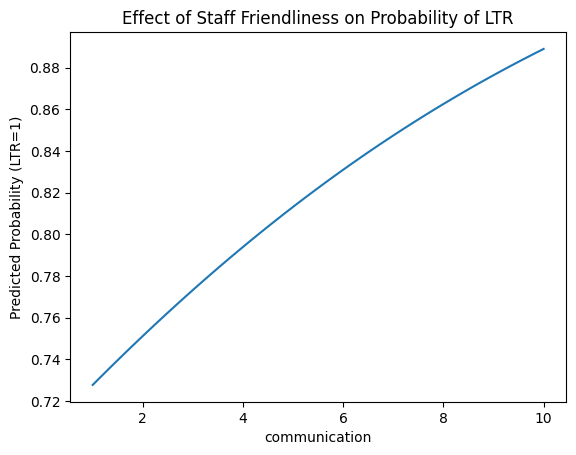

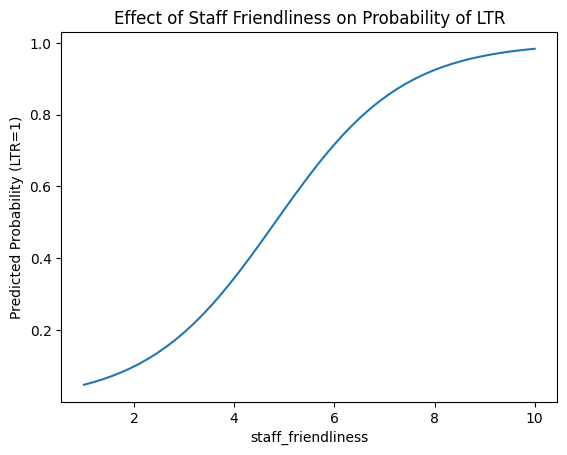

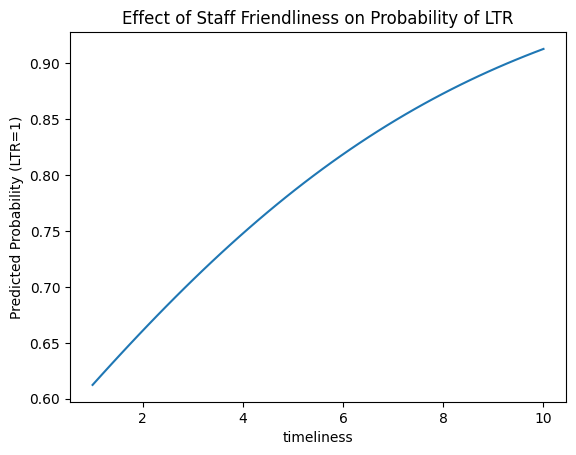

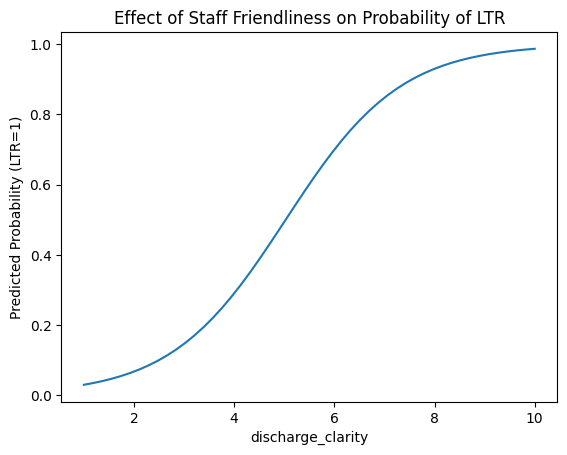

In [89]:


# -----------------------------
# 6. Visualize predicted probabilities
# -----------------------------
# Example: vary staff_friendliness while holding others constant


value_range = np.linspace(1, 10, 50)
default_val = [7]*50
starter = pd.DataFrame({
    'cleanliness': default_val,
    'communication': default_val,
    'staff_friendliness': default_val,
    'timeliness': default_val,
    'discharge_clarity': default_val
})


for field in starter.keys():
    example = pd.DataFrame()
    for c in starter.keys():
        if c == field:
            example[c] = value_range
        else:
            example[c] = default_val

    example_scaled = scaler.transform(example)
    example['predicted_prob'] = model.predict_proba(example_scaled)[:,1]

    sns.lineplot(x=field, y='predicted_prob', data=example)
    plt.title("Effect of Staff Friendliness on Probability of LTR")
    plt.ylabel("Predicted Probability (LTR=1)")
    plt.show()

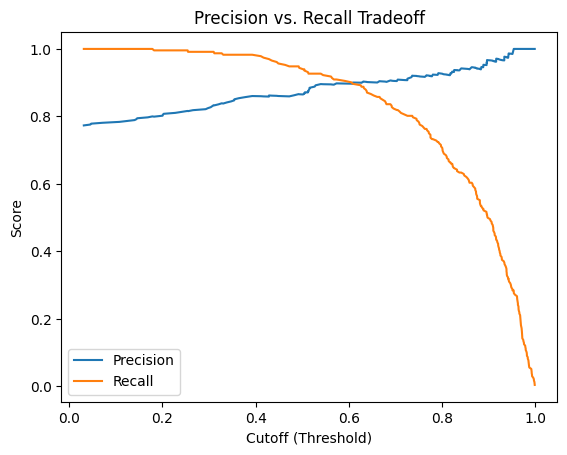

In [90]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_prob)
sns.lineplot(x=thresh, y=prec[:-1], label='Precision')
sns.lineplot(x=thresh, y=rec[:-1], label='Recall')
plt.xlabel("Cutoff (Threshold)")
plt.ylabel("Score")
plt.title("Precision vs. Recall Tradeoff")
plt.show()